The Shubert objective function
$$
f(x, y) = \left(\sum_{i=1}^5 i \, \cos( (i+1)\, x +i)\right)\left(\sum_{i=1}^5 i \, \cos( (i+1)\, y +i)\right)
$$
 is defined over the square $[-10, 10]^2$

In [1]:
using Globtim
include("../src/lib_func.jl") # Include the library of functions

# Constants and Parameters
d = 8 # Initial Degree 
const n, a, b = 2, 2, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 5e-2             # Define the tolerance for the L2-norm

f = shubert; # Function to be optimized

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/georgy/.julia/compiled/v1.10/Globtim/MzlGk_vcqj8.ji.pidfile
└ @ FileWatching.Pidfile /home/georgy/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244
┌ Warning: attempting to remove probably stale pidfile
│   path = "/home/georgy/.julia/compiled/v1.10/LinearSolve/WR6RC_vcqj8.ji.pidfile"
└ @ FileWatching.Pidfile ~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244
┌ Warning: attempting to remove probably stale pidfile
│   path = "/home/georgy/.julia/compiled/v1.10/SciMLBase/jigfq_vcqj8.ji.pidfile"
└ @ FileWatching.Pidfile ~/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/share/julia/stdlib/v1.10/FileWatching/src/pidfile.jl:244


In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end;

current L2-norm: 2.0737582664929666
Number of samples: 17
current L2-norm: 1.6297152049494217
Number of samples: 21
current L2-norm: 1.3646873393786787
Number of samples: 24
current L2-norm: 1.1179775101297367
Number of samples: 28
current L2-norm: 0.970825405673492
Number of samples: 31
current L2-norm: 0.8059430651519142
Number of samples: 35
current L2-norm: 0.6426650708795211
Number of samples: 39
current L2-norm: 0.5216788326426407
Number of samples: 44
current L2-norm: 0.42168138232378344
Number of samples: 48
current L2-norm: 0.32057926758481453
Number of samples: 53
current L2-norm: 0.25133447299228634
Number of samples: 58
current L2-norm: 0.19545970200879084
Number of samples: 63
current L2-norm: 0.1214132286374431
Number of samples: 68
current L2-norm: 0.10236538089407675
Number of samples: 74
attained the desired L2-norm: 0.04584703328902683


In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs)
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(ap .* MonomialVector(x, 0:d))
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)
println("The system is of degree:", d-1)

Check
The system is of degree:21


In [4]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false);

Tracking 441 paths...   0%|▏                            |  ETA: 1:37:43



Tracking 441 paths...  21%|██████▏                      |  ETA: 0:01:45



Tracking 441 paths...  27%|███████▊                     |  ETA: 0:01:18



Tracking 441 paths...  31%|█████████                    |  ETA: 0:01:04



Tracking 441 paths...  37%|██████████▋                  |  ETA: 0:00:50



Tracking 441 paths...  42%|████████████▎                |  ETA: 0:00:40



Tracking 441 paths...  47%|█████████████▊               |  ETA: 0:00:33



Tracking 441 paths...  52%|███████████████▎             |  ETA: 0:00:27



Tracking 441 paths...  60%|█████████████████▍           |  ETA: 0:00:20



Tracking 441 paths...  67%|███████████████████▌         |  ETA: 0:00:15



Tracking 441 paths...  73%|█████████████████████▎       |  ETA: 0:00:11



Tracking 441 paths...  81%|███████████████████████▌     |  ETA: 0:00:07



Tracking 441 paths...  89%|█████████████████████████▊   |  ETA: 0:00:04



Tracking 441 paths...  96

In [5]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z=h_z) # Create a DataFrame

Row,x,y,z
,Float64,Float64,Float64
1,1.98099,1.82638,3.07932
2,-1.96753,1.86845,-14.9977
3,-1.98424,1.98461,-6.59786
4,1.99332,-1.79471,-0.99731
5,1.92101,1.92101,3.9892
6,1.86845,-1.96753,-14.9977
7,1.82638,1.98099,3.07932
8,-1.79471,1.99332,-0.99731
9,0.826904,1.97206,4.80253


┌ Warning: attempting to remove probably stale pidfile
│   path = /home/georgy/.jlassetregistry.lock
└ @ Pidfile /home/georgy/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


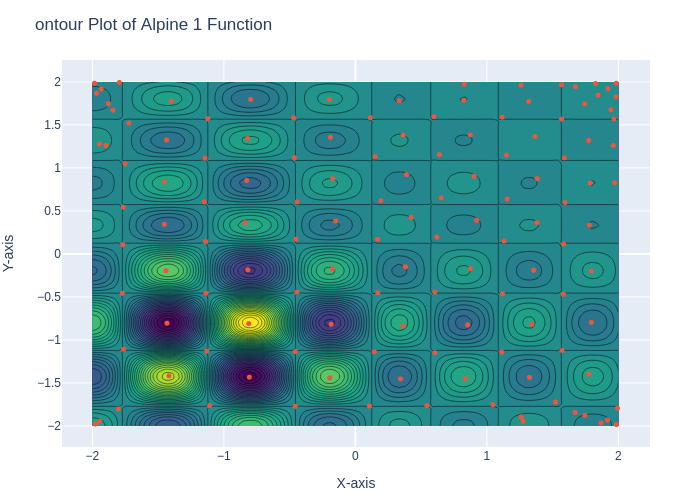

In [6]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 80  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=40, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="ontour Plot of Alpine 1 Function",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))



In [7]:
# Optimize the collected entries 
using Optim
for i in 1:nrow(df)
    println("Optimizing for point $i")
    x0 = [df.x[i], df.y[i]]
    res = Optim.optimize(f, x0, LBFGS(), Optim.Options(show_trace=true))
    minimizer = Optim.minimizer(res)
    min_value = Optim.minimum(res)
    steps = res.iterations
    converged = Optim.converged(res)
    distance = norm(x0 - minimizer)

    # df.local_minima[i] = min_value
    # df.distance_to_minima[i] = distance
    # df.steps[i] = steps
    # df.converged[i] = converged

    println(summary(res))
end


Optimizing for point 1
Iter     Function value   Gradient norm 
     0     3.079316e+00     4.375904e+01
 * time: 0.026058197021484375
     1    -1.171886e+00     3.427218e+01
 * time: 1.2140560150146484
     2    -4.505487e+01     4.837123e+01
 * time: 1.2142109870910645
     3    -4.580187e+01     3.850207e+01
 * time: 1.2143189907073975
     4    -4.775334e+01     9.326690e+01
 * time: 1.2143990993499756
     5    -4.790489e+01     9.637683e+01
 * time: 1.2144880294799805
     6    -5.203567e+01     5.150943e+00
 * time: 1.2146110534667969
     7    -5.205040e+01     1.145897e-01
 * time: 1.2146971225738525
     8    -5.205040e+01     3.345282e-05
 * time: 1.214773178100586
     9    -5.205040e+01     1.283864e-09
 * time: 1.2148540019989014
L-BFGS
Optimizing for point 2
Iter     Function value   Gradient norm 
     0    -1.499770e+01     4.212665e+01
 * time: 3.0040740966796875e-5
     1    -2.695128e+01     7.028400e+01
 * time: 0.00024890899658203125
     2    -2.774008e+01     7

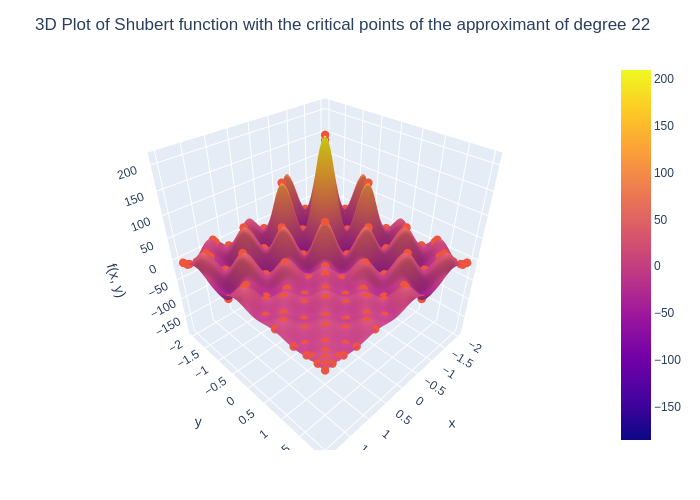

In [8]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of Shubert function with the critical points of the approximant of degree 22",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
    height=800
)
# Display the plot layout,
plt = plot([sf, crit_pts], layout)

In [9]:
savefig(plt, "../data/figures/shubert_function_plot.html")

"../data/figures/shubert_function_plot.html"